In [2]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.vaep as vaep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [4]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


In [11]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left",)
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:03<00:00, 17.48it/s]


Index(['game_id', 'period_id', 'action_id', 'time_seconds', 'timestamp',
       'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id', 'bodypart_id',
       'type_name', 'bodypart_name', 'country_id', 'country_name', 'extra',
       'jersey_number', 'player_name', 'player_nickname', 'team_name',
       'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-21 France 1-0 Peru 31' interception Alberto Junior Rodríguez Valdelomar


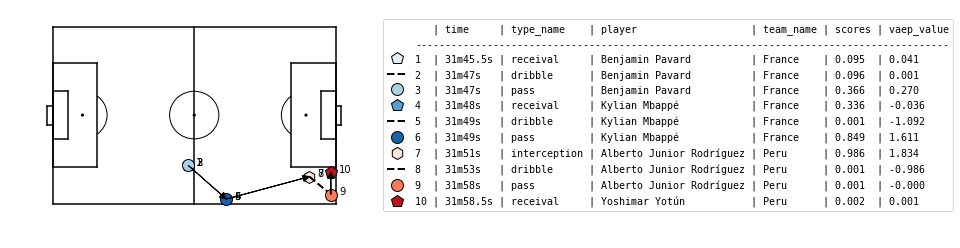

2018-06-21 France 1-0 Peru 31' pass Kylian Mbappé Lottin


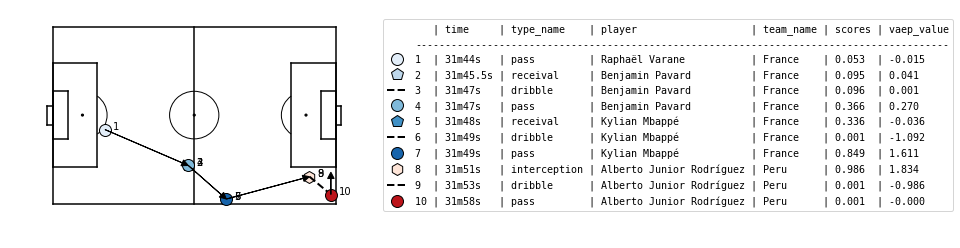

2018-06-24 Japan 2-2 Senegal 3' interception Moussa Wagué


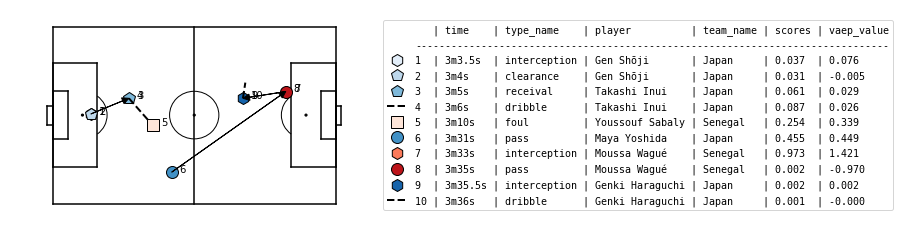

2018-06-24 Poland 0-3 Colombia 35' receival Johan Andrés Mojica Palacio


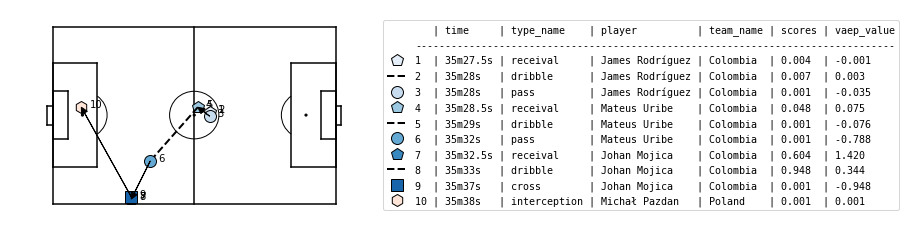

2018-06-15 Morocco 0-1 Iran 47' pass Roozbeh Cheshmi


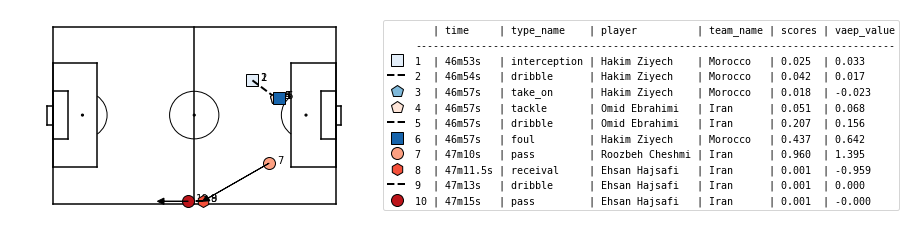

2018-06-21 Denmark 1-1 Australia 6' pass Nicolai Jørgensen


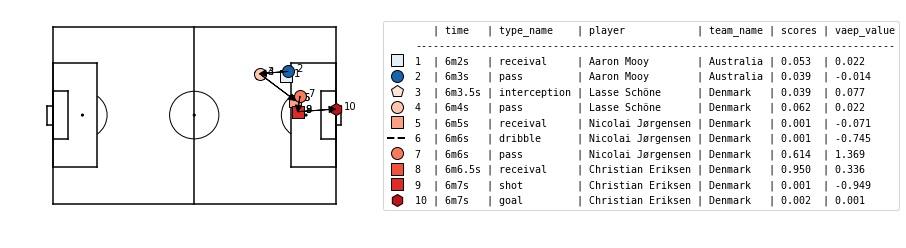

2018-06-28 England 0-1 Belgium 54' pass Leander Dendoncker


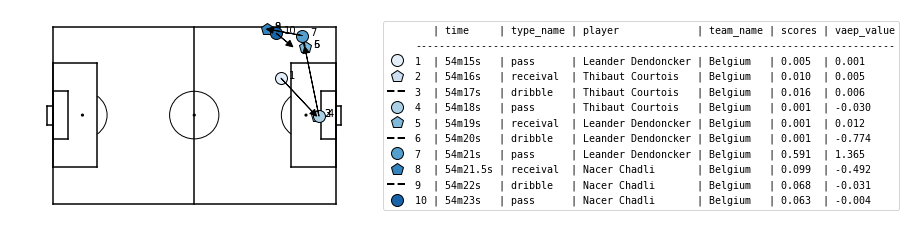

2018-06-16 Argentina 1-1 Iceland 59' pass Wilfredo Daniel Caballero


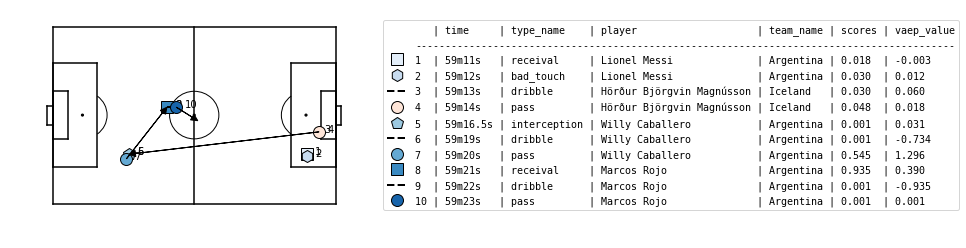

2018-06-18 Belgium 3-0 Panama 15' dribble Aníbal Cesis Godoy


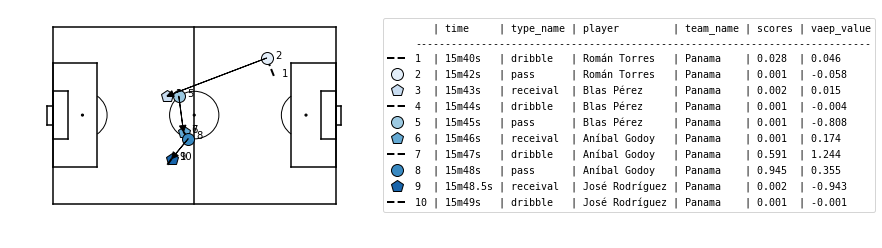

2018-06-16 Peru 0-1 Denmark 2' pass Thomas Delaney


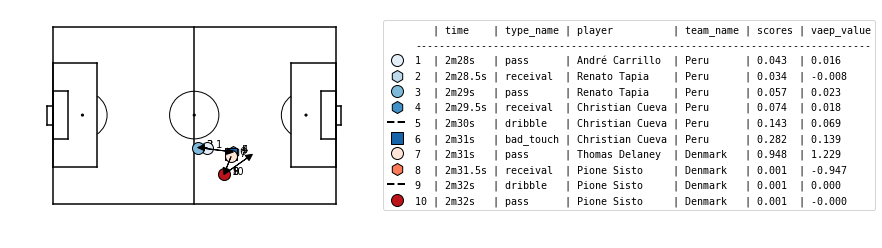

In [13]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
#sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
#sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 6 : i+4].copy()
    
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x","y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                #result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)